<a href="https://colab.research.google.com/github/Nenad523/mastering-git/blob/main/Neural_Network_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* **Regression** (completed in previous lesson) is used for prediction numbers, from one or more dependant variables.
* **Classification** is used for predicting different things.

### There are different types of classification:
1. **Binary classification** (one thing or another) - predicting whether answer to something is one thing or another. Is this email spam or not? Usually, models are trained for this to predict whether answer is yes or no. If the model can classify something in two groups, it is BC.
2. **Multiclass classification** (more than one thing or another) - when there are multiple choices to predict on. For example, machine is offered a photo, and a query, is food on photo sushi, pizza or stake. Now it is not predicting if it is one or the other, but it is rather predicting, which one from the group of possible answer, it could be. Hence, multiclass, because the answers are called classes.
3. **Multilabel classification** - similiar to the one above, but the difference is that in MCC, in ideal world, you assign every feature (photo in our case) only one label (sushi, pizza or stake). In MLC, you can assign multiple labels to one feature. For example, you are offered a article, and you need to give an answer to what tags this article should have. And it can have multiple articles: Food, drinks, quisine and more.

  ## Classification inputs and outputs
   

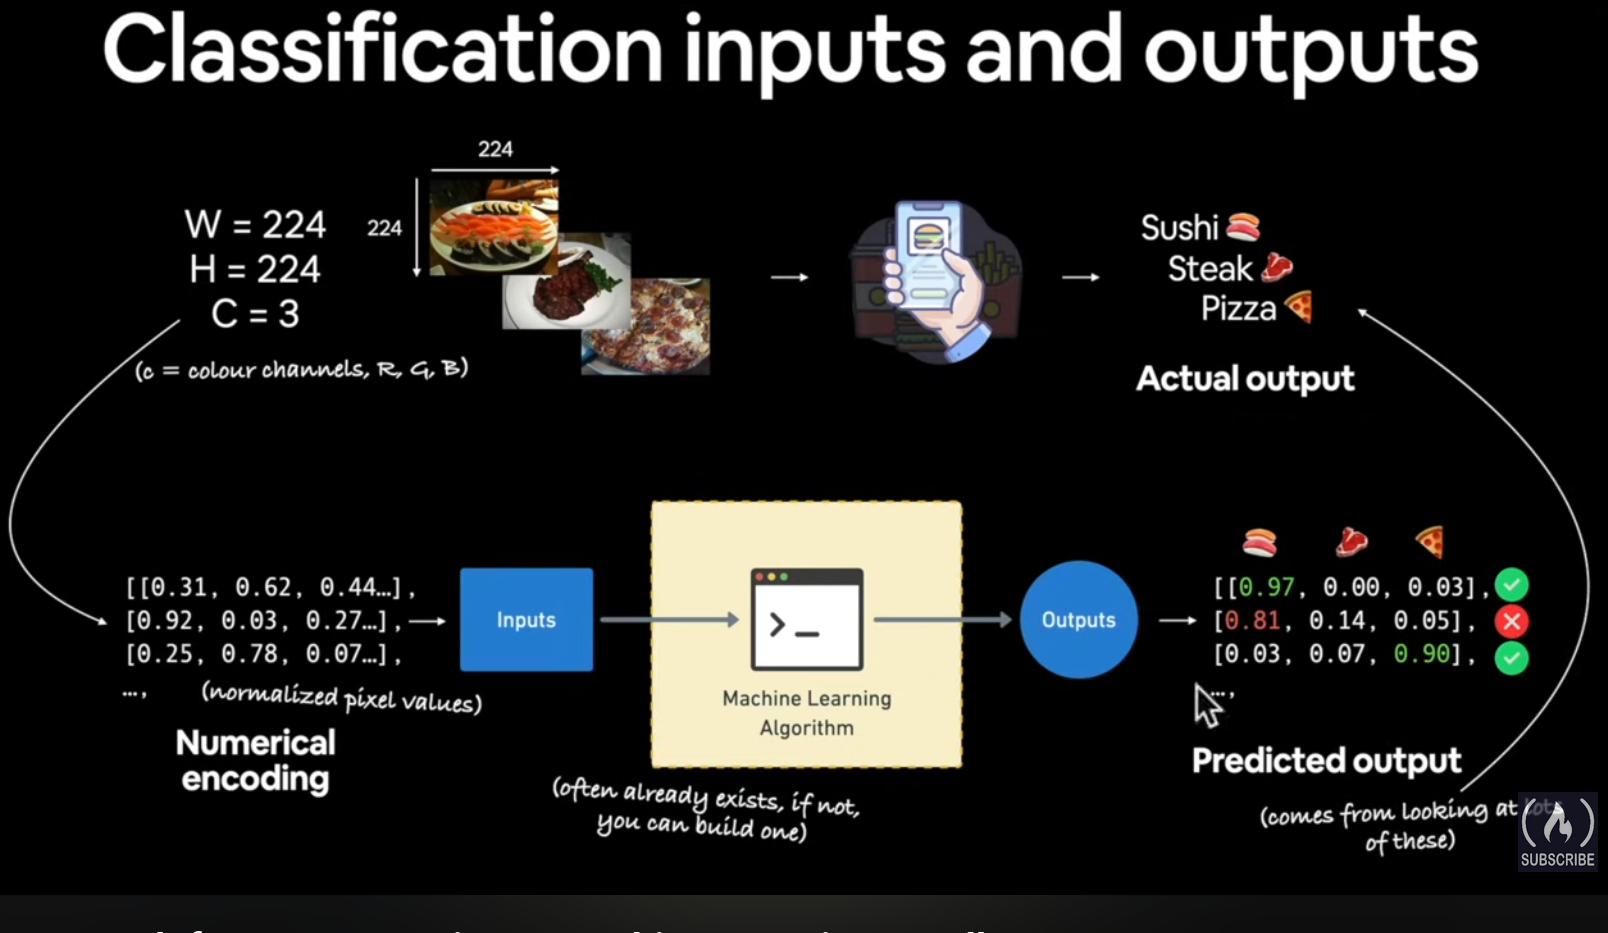

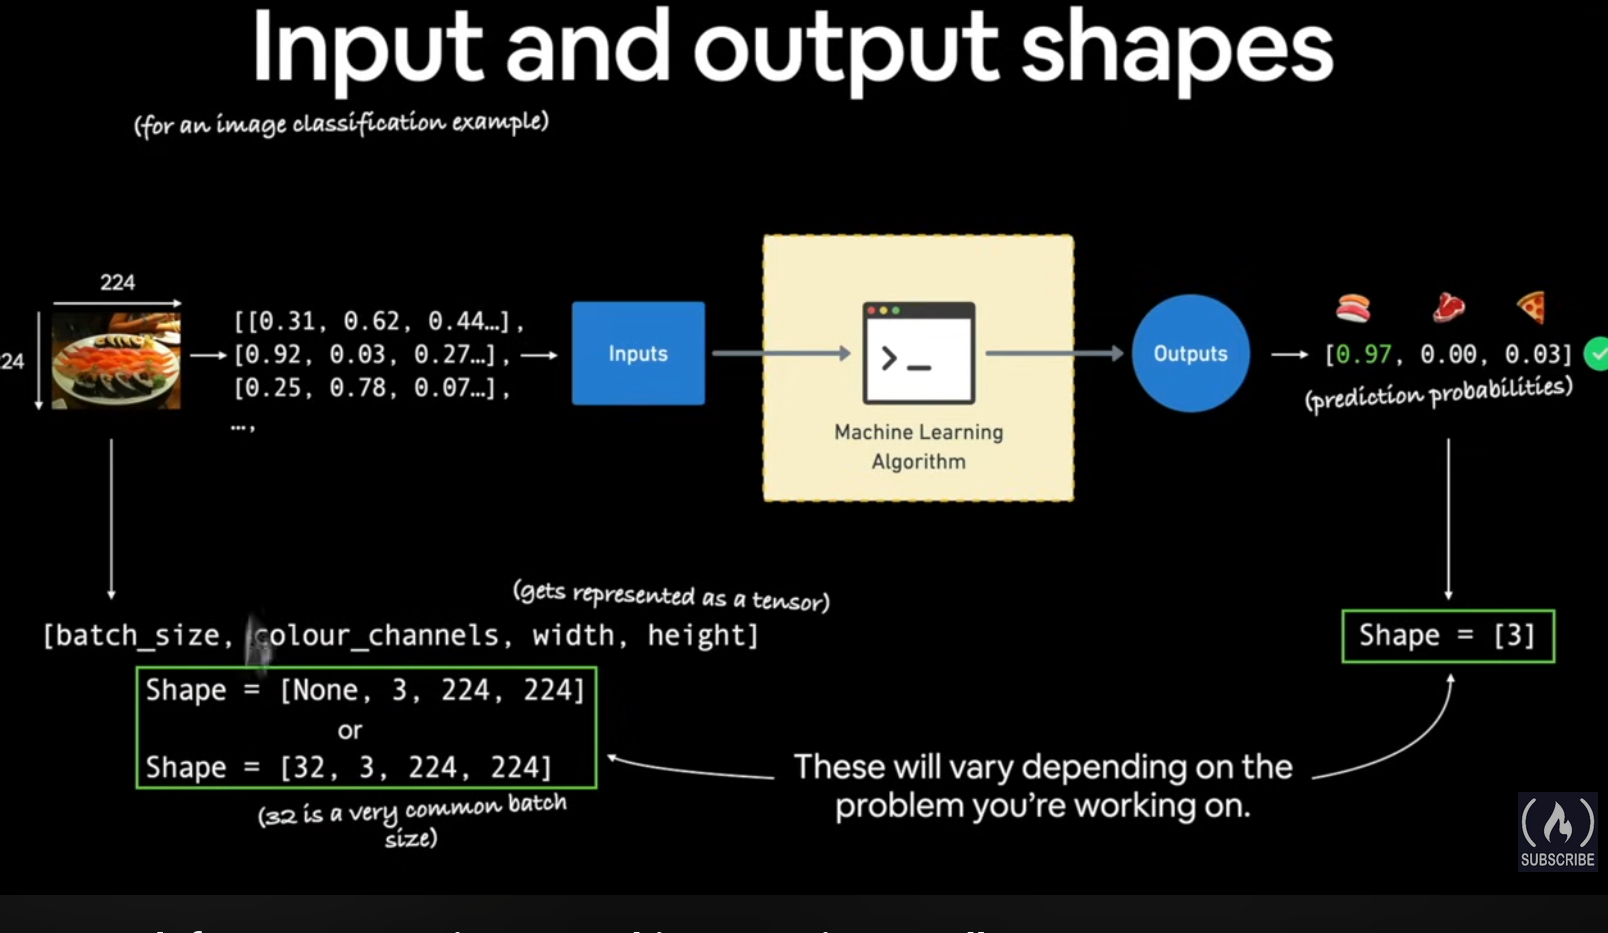

In [8]:
# Batch size - how many features (in this case photos) can the model process at once.

## Architecture of a classification neural network

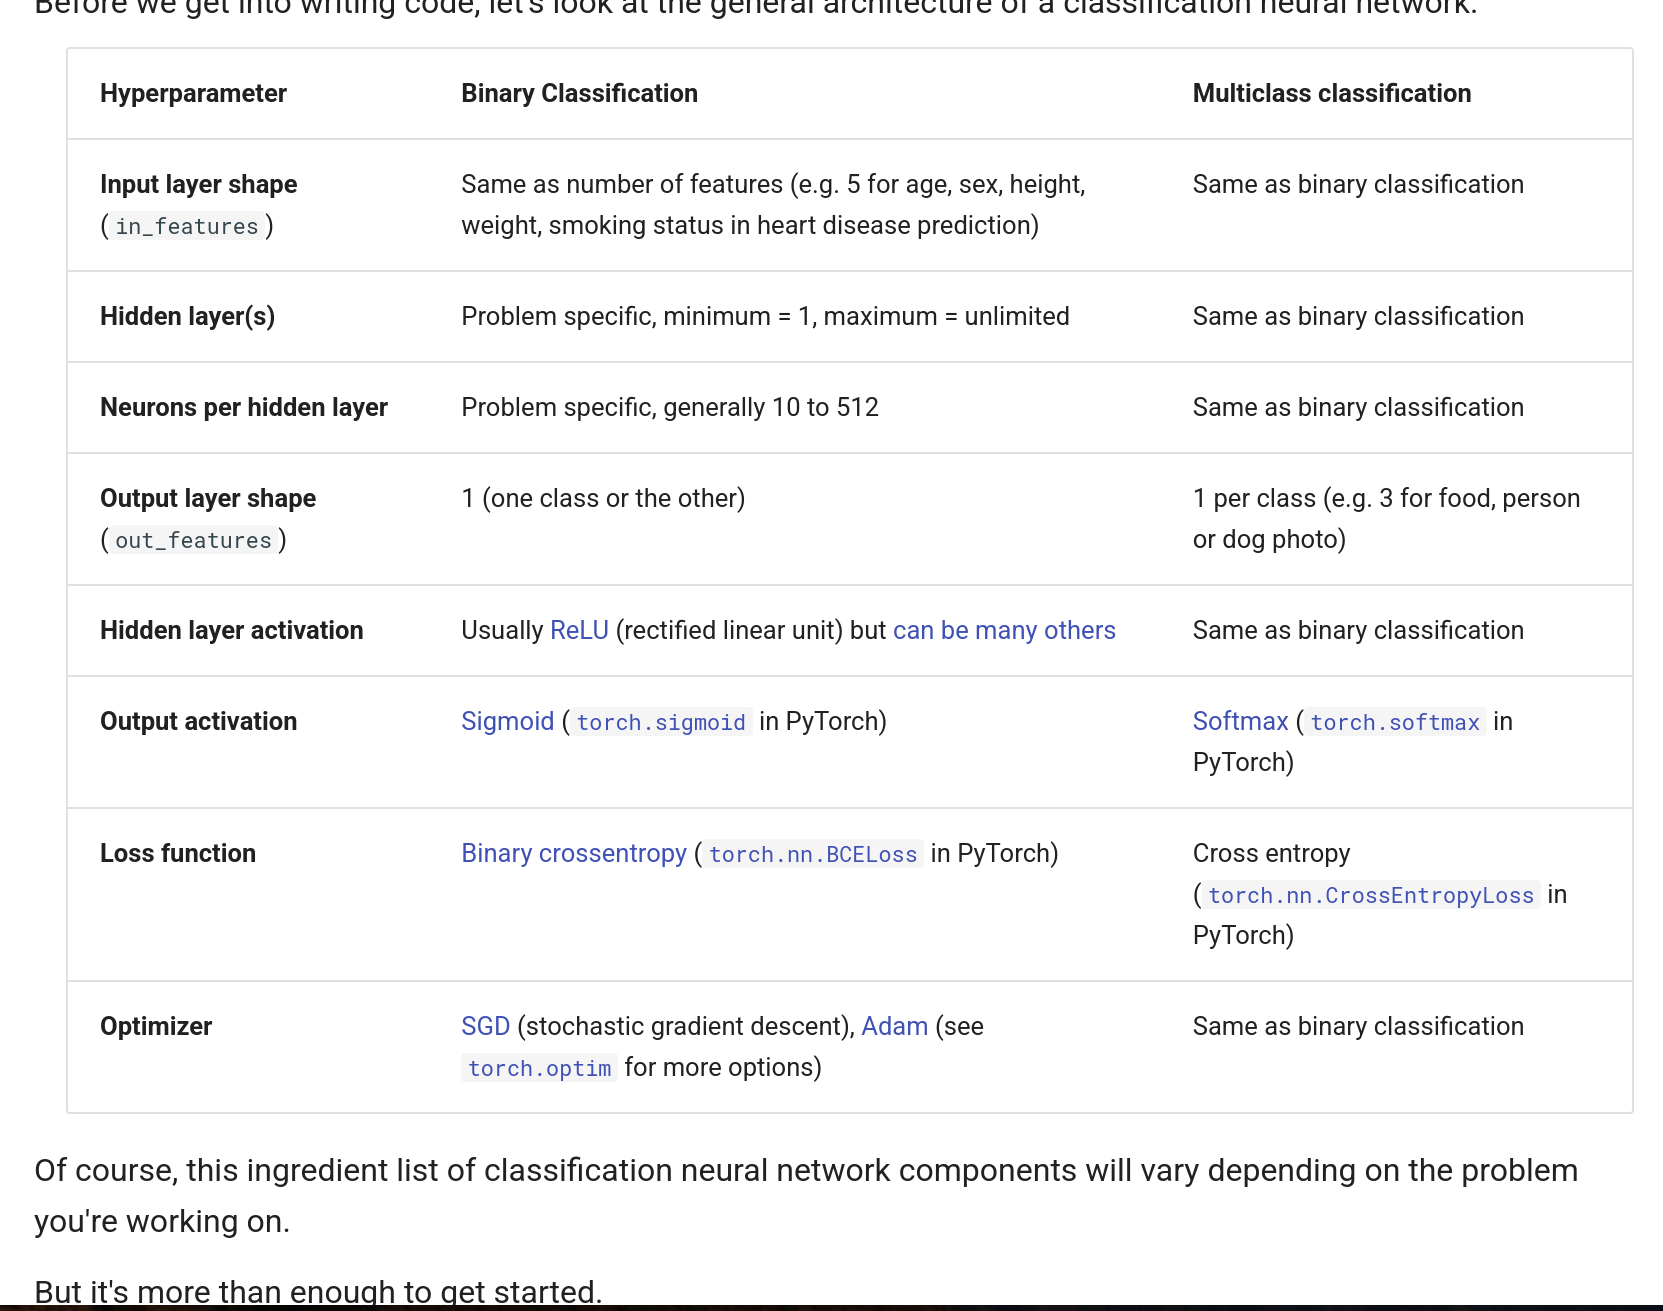

  # 02. Neural Network classification with PyTorch

## 1. Make classification data and get it ready

In [9]:
import sklearn
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42) # <-> Setting RANDOM_SEED for reproducibilty


In [10]:
len(X), len(y)

(1000, 1000)

In [11]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n  {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
  [1 1 1 1 0]


In [12]:
# Make DataFrame of circle data
import pandas as pd

circles = pd.DataFrame({"X1" : X[:, 0],
                        "X2" : X[:, 1],
                        "label" : y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


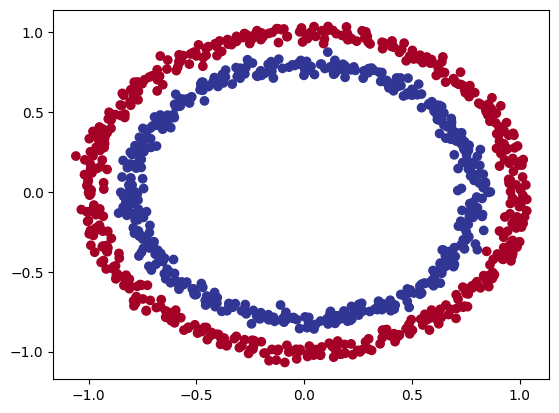

In [13]:
# Visualizwe, visualize, visualize
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

**Note**: The data we're working with is often referred to as a **toy dataset**, a dataset that is small enough to experiment, but still sizeable enough to practice the fundamentals.

### 1. Check input and output shapes

In [14]:
X.shape, y.shape

((1000, 2), (1000,))

In [15]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: 1


## 1.2 Turn data into tensors and create train and test splits

In [16]:
import torch
torch.__version__

'2.8.0+cu126'

In [17]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [18]:
X.dtype, y.dtype

(torch.float32, torch.float32)

In [19]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,# 0.2 = 20% of data will be test and rest will be train
                                                    random_state=42)


In [20]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agnostic code, so our code will run on an accelerator (GPU) if there is one
2. Construct a model (by sublclassing nn.Module)
3. Define a loss function and optimizer
4. Create a trianing and testing loop

In [21]:
# import PyTorch and nn
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [22]:
X_train

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]])

Now we've setup device agnostic code, let's create a model that:

1. Subclass nn.Module.
2. Create 2 nn.Linear layers that are capable of handling the shapes of our data.
3. Define a `forward()` method that outlines the forward pass (or forward computation) of the model
4. Instantiate an instance of our model class and send it to the target device

In [23]:
X_train.shape

torch.Size([800, 2])

In [24]:
y_train[:5]

tensor([1., 0., 0., 0., 1.])

In [25]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    # 2. Create 2 nn.Linear layers
    self.layer_1 = nn.Linear(in_features=2,
                             out_features=5) # Takes in 2 features, and upscale it to 5 features

    self.layer_2 = nn.Linear(in_features=5,
                             out_features=1) # Takes in 5 features from previous layer and outputs 1 feature



  # 3. Define a forward method that outlines the forward pass
  def forward(self, x : torch.Tensor) -> torch.Tensor:
      return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output


# 4. Instantiate a instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [26]:
model_0.state_dict

<bound method Module.state_dict of CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)>

In [27]:
# Let's replicate the model above using nn.Sequential()

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [28]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.6675,  0.0289],
                      [ 0.4943, -0.1099],
                      [-0.5938,  0.6284],
                      [ 0.5607, -0.2096],
                      [-0.1132, -0.0974]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.4983,  0.6092, -0.3011, -0.1177, -0.6050], device='cuda:0')),
             ('1.weight',
              tensor([[-0.1719, -0.0234,  0.2254, -0.3442, -0.2221]], device='cuda:0')),
             ('1.bias', tensor([0.0500], device='cuda:0'))])

In [29]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape : {untrained_preds.shape}")
print(f"Length of test sample : {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predicitions: \n{torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 200, Shape : torch.Size([200, 1])
Length of test sample : 200, Shape: torch.Size([200, 2])

First 10 predicitions: 
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [-0.],
        [-0.],
        [0.],
        [-0.],
        [0.],
        [0.]], device='cuda:0')

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [30]:
X_test[:10], y_test[:10]

(tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

### 2.1 Setup loss function and optmizier

Which loss function or optimizer should you use?
Again... This is problem specific, but you get used to which one to use, by practicing.

For example fro regresiion you mihgt want to use MAE or MSE.
For classification, you migh want binary cross entropy or categorical cross entropy (cross entropy).

As a reminder, loss function is used to determine how poor your model is performing.

And for optimizers, two of the most common and useful are SGD and Adam.

* For the loss function we're going to use `torch.BCEWithLogitsLoss()`.

In [31]:
# Setup the loss function
loss_fn = nn.BCEWithLogitsLoss() # Has sigmoid activation function built in

optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.1)

In [32]:
# Calculate accuracy (evaluation our model) - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item() # How many of y_true are equal to y_pred
  acc = (correct/len(y_pred)) * 100
  return acc

## 3. Training a model

To trian our model, we need to build a training loop:

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backwards (backpropagation)
5. Optimizer step

## 3.1 Going from raw logits -> predicition probabilities  -> prediction labels

Our model outputs are going to be raw **logits**.

We can convert these **logits** into prediction probabilites by passing them to som ekind of activatio nfunctino (e.g. sigmoid for binary classification and softmax for multiclass classifictaion).

Then we can convert our model's prediction probabilites to **prediction labels** by either oudnign them or taking the `argmax()`.

In [33]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.2906],
        [ 0.2777],
        [ 0.1232],
        [ 0.3389],
        [-0.1961]], device='cuda:0')

In [34]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [35]:
# Use the sigmoid activation function on our model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5721],
        [0.5690],
        [0.5308],
        [0.5839],
        [0.4511]], device='cuda:0')

For our prediction probabiltiy valies, we need to perfrom a range-style rounding on them:
* `y_pred_probs` >= 0.5, `y=1` (class 1)
* `y_pred_probs` < 0.5, `y=0` (class 2)

In [36]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

tensor([True, True, True, True, True], device='cuda:0')


In [37]:
torch.cuda.manual_seed(42)

In [38]:
### 3.2 Building a training and testing loop

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  # Training loop
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Calculate the loss/accuracy
  loss = loss_fn(y_logits, ## nn.BCEWithLogitsLoss expect raw logits as input, and BSELoss would expect pred probab
                 y_train)

  acc = accuracy_fn(y_train, y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()

  # 5. Optimizer step
  optimizer.step()


  # Testing loop
  model_0.eval()

  with torch.inference_mode():
    # 1. Forward pass
    y_test_logits = model_0(X_test).squeeze()
    y_test_pred = torch.sigmoid(y_test_logits)

    # 2. Calculate the loss
    test_loss = loss_fn(y_test_logits, y_test)
    test_acc = accuracy_fn(y_test, y_test_pred)


  # Print out what is happening
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss :{loss: 5f}, Acc: {acc: 2f}% | Test loss :{test_loss:5f}. Test acc {test_acc: 2f}%")

Epoch: 0 | Loss : 0.697604, Acc:  51.125000% | Test loss :0.700806. Test acc  0.000000%
Epoch: 10 | Loss : 0.696128, Acc:  51.125000% | Test loss :0.699396. Test acc  0.000000%
Epoch: 20 | Loss : 0.695172, Acc:  51.000000% | Test loss :0.698476. Test acc  0.000000%
Epoch: 30 | Loss : 0.694532, Acc:  50.875000% | Test loss :0.697850. Test acc  0.000000%
Epoch: 40 | Loss : 0.694096, Acc:  50.625000% | Test loss :0.697410. Test acc  0.000000%
Epoch: 50 | Loss : 0.693794, Acc:  50.500000% | Test loss :0.697092. Test acc  0.000000%
Epoch: 60 | Loss : 0.693584, Acc:  50.750000% | Test loss :0.696857. Test acc  0.000000%
Epoch: 70 | Loss : 0.693437, Acc:  51.000000% | Test loss :0.696677. Test acc  0.000000%
Epoch: 80 | Loss : 0.693333, Acc:  51.125000% | Test loss :0.696536. Test acc  0.000000%
Epoch: 90 | Loss : 0.693258, Acc:  51.375000% | Test loss :0.696422. Test acc  0.000000%


In [39]:
y_test_logits = model_0(X_test)
y_test_logits, y_test_logits.shape

(tensor([[ 0.0825],
         [ 0.1164],
         [-0.0342],
         [ 0.1157],
         [-0.0785],
         [-0.0575],
         [ 0.0730],
         [ 0.0322],
         [-0.0322],
         [ 0.1182],
         [ 0.0942],
         [ 0.0881],
         [ 0.0524],
         [-0.0636],
         [-0.0273],
         [ 0.0007],
         [ 0.0862],
         [ 0.0847],
         [ 0.0647],
         [ 0.0554],
         [ 0.1195],
         [-0.0151],
         [ 0.0518],
         [ 0.0727],
         [ 0.0946],
         [ 0.0517],
         [-0.1070],
         [-0.0507],
         [-0.0271],
         [-0.0692],
         [ 0.0639],
         [ 0.1014],
         [ 0.1022],
         [-0.0875],
         [ 0.1015],
         [ 0.0966],
         [ 0.0998],
         [-0.0562],
         [-0.0891],
         [-0.0676],
         [ 0.0482],
         [-0.0138],
         [ 0.0825],
         [-0.0951],
         [ 0.1088],
         [ 0.0975],
         [-0.0804],
         [ 0.1240],
         [ 0.0906],
         [-0.0660],


## 4. Make predictions and evaluate the model

From the metrics it looks like our model isn't learning anything...

So to inspect it let's make some predictinsa and make them visual!

To do so, we're going to import a functipn called `plot_decision_boundary()`

In [40]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping downlaod.")
else:
  print("Download helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary


Download helper_functions.py


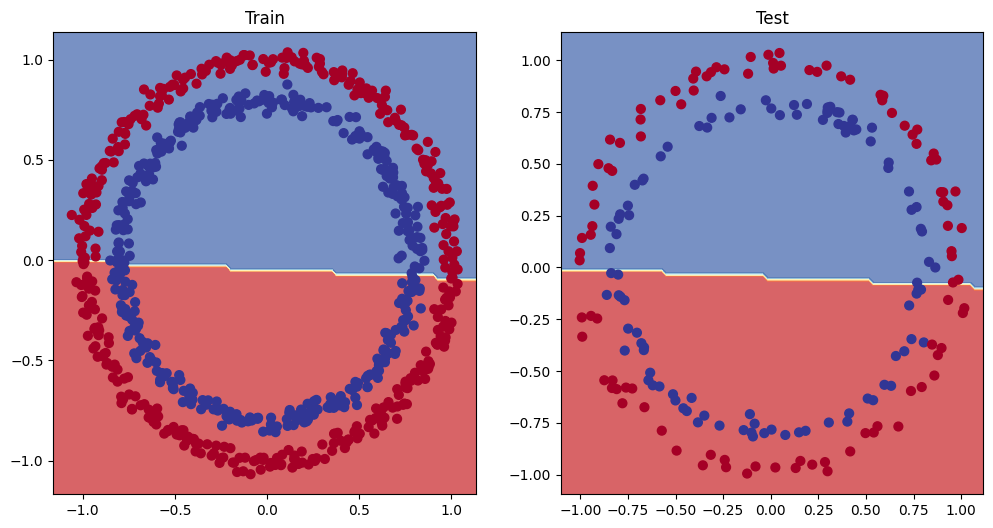

In [41]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden to 10 hidden units
* Train for longer
* Changing the activation function
* Change the learning rate
* Change the loss function

Let's try and improve our model by:
* Adding more hidden units: 5 -> 10
* Increase the number of layers : 2->3
* increase the number of epochs: 100->1000

In [42]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features=2,
                             out_features=10)

    self.layer_2 = nn.Linear(in_features=10,
                             out_features=10)

    self.layer_3 = nn.Linear(in_features=10,
                             out_features=1)

  def forward(self, x : torch.Tensor) -> torch.Tensor:
    #z = self.layer_1(x)
    #z = self.layer_2(z)
    #z = self.layer_3(z)
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [43]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()
# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr = 0.1)

In [44]:
# Create a training and testing loop for new model
torch.cuda.manual_seed(42)
epochs = 1000

for epoch in range(epochs):

  # Training loop
  model_1.train()

  # 1.Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Calculate the loss and accuracy
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  # Testing loop
  model_1.eval()

  # 1. Forward pass
  with torch.inference_mode():
    y_test_logit = model_1(X_test).squeeze()
    y_test_pred = torch.round(torch.sigmoid(y_test_logit))

    # 2. Calculate the loss and accuracy
    test_loss = loss_fn(y_test_logit, y_test)
    test_acc = accuracy_fn(y_test, y_test_pred)

  # Print out what is happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss :{loss: 5f}, Acc: {acc: 2f}% | Test loss :{test_loss:5f}. Test acc {test_acc: 2f}%")

Epoch: 0 | Loss : 0.733207, Acc:  50.000000% | Test loss :0.717934. Test acc  50.000000%
Epoch: 100 | Loss : 0.693418, Acc:  50.500000% | Test loss :0.693128. Test acc  47.000000%
Epoch: 200 | Loss : 0.693022, Acc:  50.625000% | Test loss :0.694109. Test acc  47.500000%
Epoch: 300 | Loss : 0.692984, Acc:  51.375000% | Test loss :0.694493. Test acc  47.000000%
Epoch: 400 | Loss : 0.692980, Acc:  51.250000% | Test loss :0.694621. Test acc  45.500000%
Epoch: 500 | Loss : 0.692980, Acc:  51.250000% | Test loss :0.694661. Test acc  46.000000%
Epoch: 600 | Loss : 0.692980, Acc:  51.125000% | Test loss :0.694674. Test acc  46.000000%
Epoch: 700 | Loss : 0.692980, Acc:  51.125000% | Test loss :0.694678. Test acc  46.000000%
Epoch: 800 | Loss : 0.692980, Acc:  51.000000% | Test loss :0.694679. Test acc  46.000000%
Epoch: 900 | Loss : 0.692980, Acc:  51.000000% | Test loss :0.694679. Test acc  46.000000%


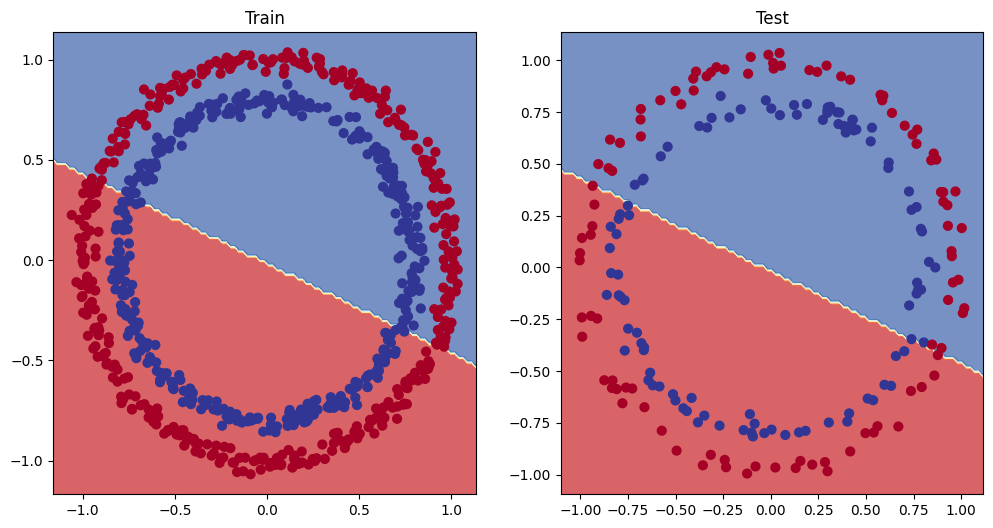

In [45]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshoot to a larger problem is to test out a smaller problem.

In [46]:
# Create some data (same as previpus lecture)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight* X_regression + bias

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [47]:
# Create train and test split
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

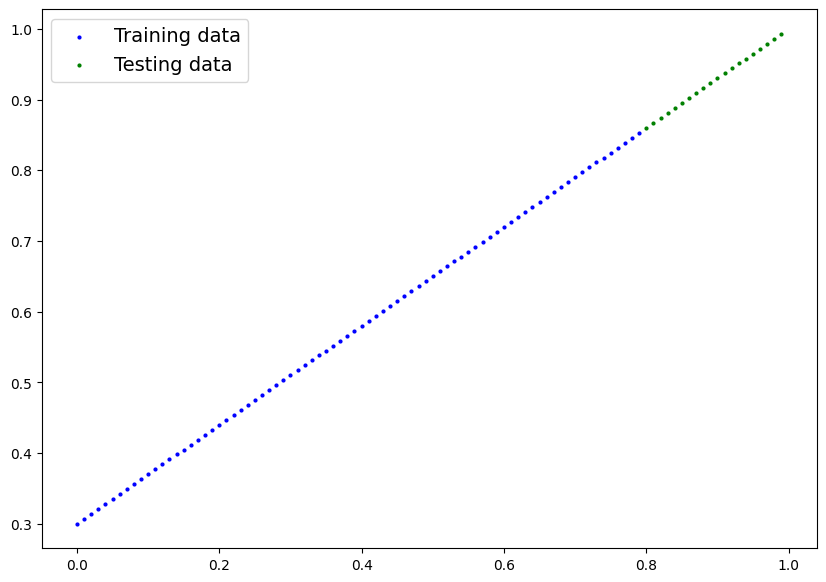

In [48]:
plot_predictions(X_train_regression,
                 y_train_regression,
                 X_test_regression,
                 y_test_regression)

In [49]:
X_train_regression[:10], y_train_regression[:10]

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400],
         [0.0500],
         [0.0600],
         [0.0700],
         [0.0800],
         [0.0900]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280],
         [0.3350],
         [0.3420],
         [0.3490],
         [0.3560],
         [0.3630]]))

### 5.2 Adjusting `model_1` to fit a straight line

In [50]:
# Same archicture as model_1 (but using nn.Sequential())
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [51]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params = model_2.parameters(),
                            lr = 0.01)


In [52]:
# Train a model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set the number of epochs
epochs = 1000

# Put the data on the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# Training
for epoch in range(epochs):
  model_2.train()
  y_pred = model_2(X_train_regression)
  loss = loss_fn(y_pred, y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing
  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss :{loss: .5f} | Test loss: {test_loss:.5f}")

Epoch: 0 | Loss : 0.55305 | Test loss: 0.97869
Epoch: 100 | Loss : 0.08319 | Test loss: 0.20673
Epoch: 200 | Loss : 0.04281 | Test loss: 0.00194
Epoch: 300 | Loss : 0.03736 | Test loss: 0.00381
Epoch: 400 | Loss : 0.03134 | Test loss: 0.00457
Epoch: 500 | Loss : 0.02598 | Test loss: 0.00558
Epoch: 600 | Loss : 0.02345 | Test loss: 0.00702
Epoch: 700 | Loss : 0.02220 | Test loss: 0.00568
Epoch: 800 | Loss : 0.02329 | Test loss: 0.00618
Epoch: 900 | Loss : 0.02112 | Test loss: 0.00611


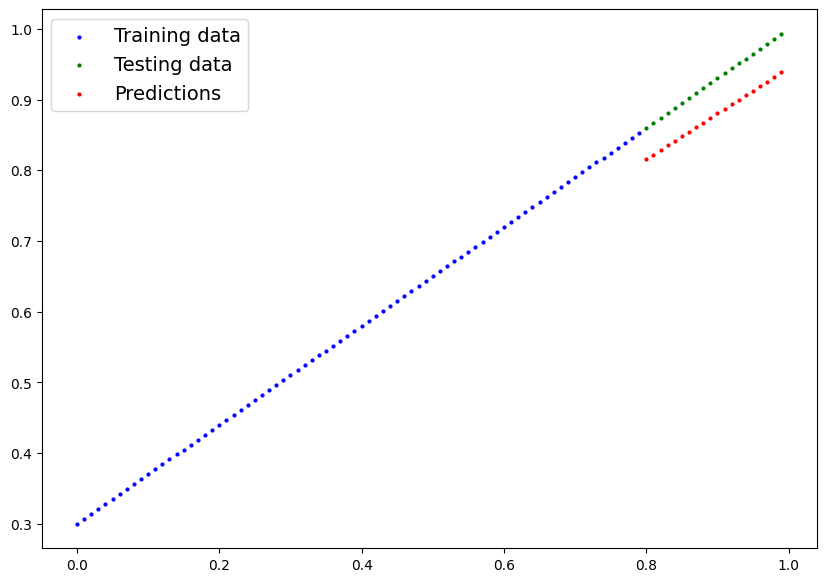

In [53]:
model_2.eval()
with torch.inference_mode():
  y_preds = model_2(X_test_regression)

plot_predictions(X_train_regression.cpu(),
                 y_train_regression.cpu(),
                 X_test_regression.cpu(),
                 y_test_regression.cpu(),
                 y_preds.cpu())

## 6. The missing piece of our model (non-linearity)

"What patterns could you draw if you ere given an infinte amount of a straight and non-straight lines?"

### 6.1 Recreating non-linaer data (red and blue circles)

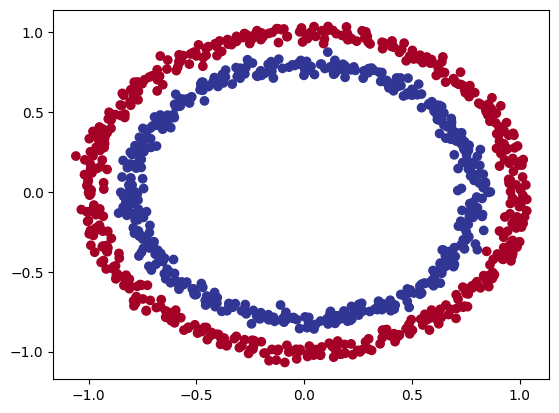

In [54]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap = plt.cm.RdYlBu)

In [55]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity

In [56]:
# Build a model with non-linear activation functions
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features=2,
                             out_features=10)

    self.layer_2 = nn.Linear(in_features=10,
                             out_features=10)

    self.layer_3 = nn.Linear(in_features=10,
                             out_features=1)

    self.relu = nn.ReLU() # Non linear activation function


  def forward(self, x):
    # Where we should put our non-linear activation functin?
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [57]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr = 0.1)

In [59]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_3.train()

  y_logit = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logit))

  loss = loss_fn(y_logit, y_train)
  acc = accuracy_fn(y_pred, y_train)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_3.eval()
  with torch.inference_mode():
    y_test_logit = model_3(X_test).squeeze()
    y_test_pred = torch.round(torch.sigmoid(y_test_logit))

    test_loss = loss_fn(y_test_logit, y_test)
    test_acc = accuracy_fn(y_test_pred, y_test)

  # Print out what is happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss :{loss: 5f}, Acc: {acc: .2f}% | Test loss :{test_loss:5f}. Test acc {test_acc: .2f}%")


Epoch: 0 | Loss : 0.692946, Acc:  50.00% | Test loss :0.693188. Test acc  50.00%
Epoch: 100 | Loss : 0.691153, Acc:  52.88% | Test loss :0.691024. Test acc  52.50%
Epoch: 200 | Loss : 0.689774, Acc:  53.37% | Test loss :0.689396. Test acc  55.00%
Epoch: 300 | Loss : 0.687949, Acc:  53.00% | Test loss :0.687232. Test acc  56.00%
Epoch: 400 | Loss : 0.685168, Acc:  52.75% | Test loss :0.684115. Test acc  56.50%
Epoch: 500 | Loss : 0.681022, Acc:  52.75% | Test loss :0.679412. Test acc  56.50%
Epoch: 600 | Loss : 0.675149, Acc:  54.50% | Test loss :0.672851. Test acc  56.00%
Epoch: 700 | Loss : 0.666589, Acc:  58.38% | Test loss :0.663216. Test acc  59.00%
Epoch: 800 | Loss : 0.651596, Acc:  64.00% | Test loss :0.647569. Test acc  67.50%
Epoch: 900 | Loss : 0.623623, Acc:  74.00% | Test loss :0.621453. Test acc  79.00%


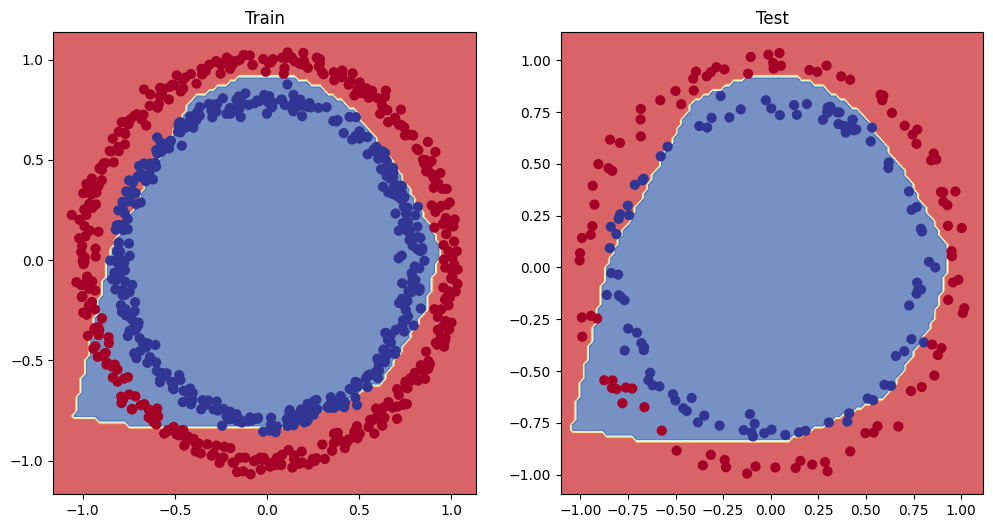

In [61]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

## 7. Replicating non-linear activation functins

erula netowrks, rather than us telling the model what to learn, we give it the tools to disvoer pattenrs in data and it tires to figure out the patterns on its own.

And rthtese tools are linear and non-linear functions

In [62]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)

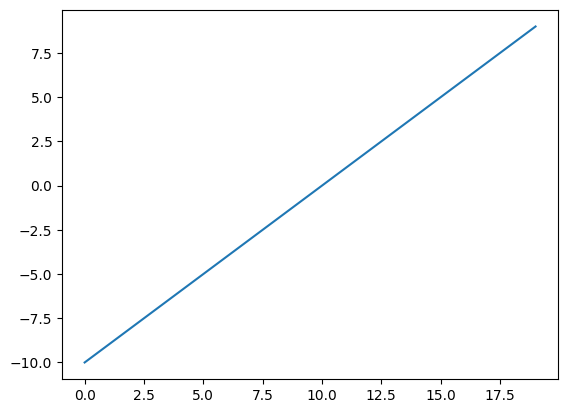

In [63]:
# Visualize the tensor
plt.plot(A)

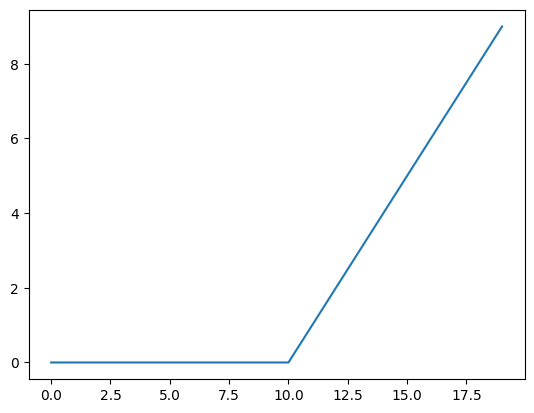

In [64]:
plt.plot(torch.relu(A))

In [65]:
def relu(x : torch.Tensor) -> torch.Tensor:
  return torch.maximum(torch.tensor(0), x)

In [66]:
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

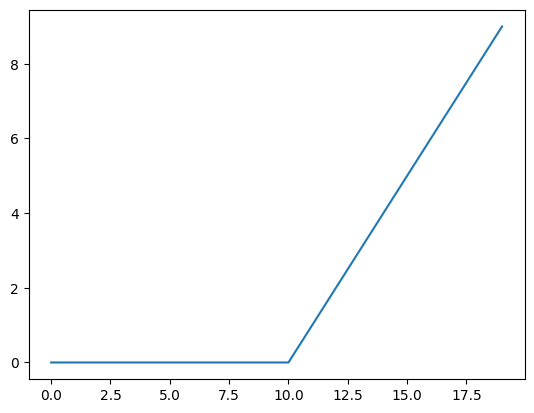

In [67]:
# Plot ReLU activation function
plt.plot(relu(A))

In [68]:
# Now lets do the same for sigmoid
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

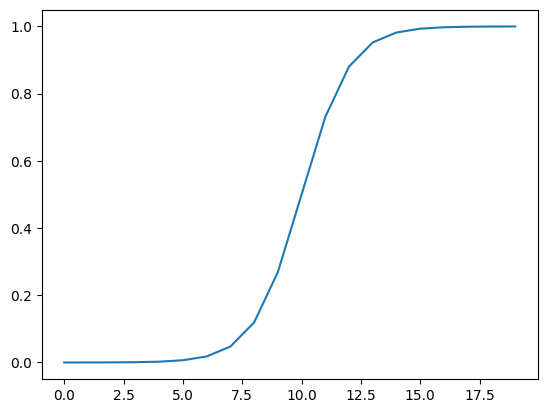

In [69]:
plt.plot(torch.sigmoid(A))

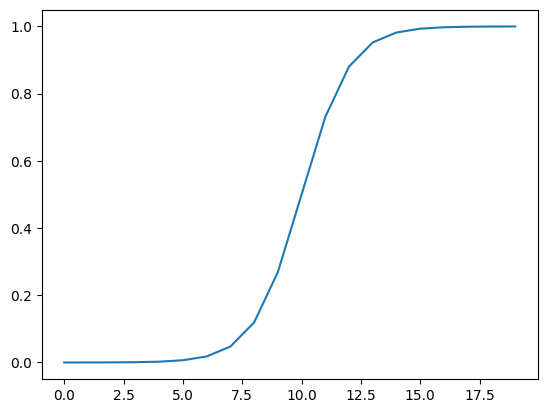

In [70]:
plt.plot(sigmoid(A))

## 8. Putting it all together with multiclass classification problem


### 8.1 Creating a toy multi-class dataset

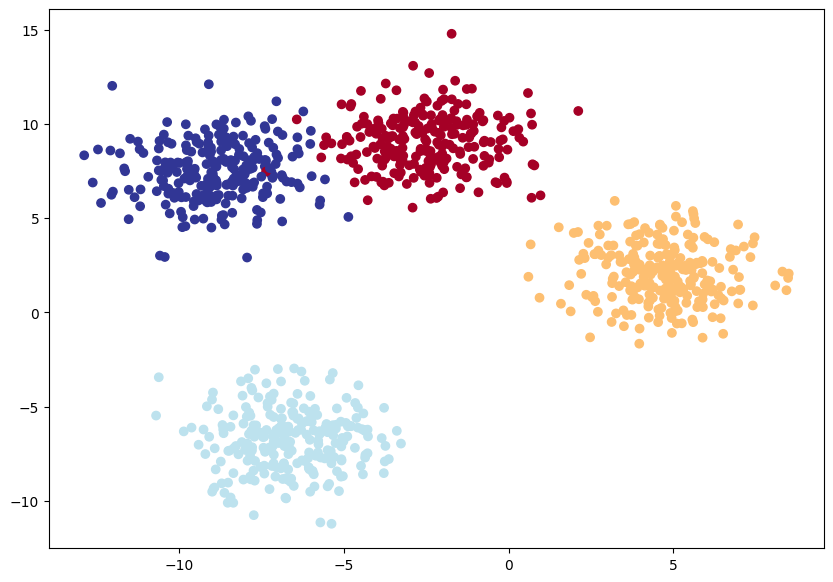

In [71]:
# Import dependicies
import torch
from torch import nn
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Set the hyperparameters fro data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multiclass data
X_blob, y_blob = make_blobs(n_samples = 1000,
                            n_features = NUM_FEATURES,
                            centers = NUM_CLASSES,
                            cluster_std = 1.5,
                            random_state = RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into training and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# 4. Plot data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c = y_blob, cmap = plt.cm.RdYlBu)


In [72]:
X_blob

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        ...,
        [ 3.2158,  5.9217],
        [-7.7939, -7.1606],
        [-9.6816,  7.0097]])

In [73]:
y_blob

tensor([3, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 3, 0, 2, 2, 2, 0, 0, 0, 1, 1, 3, 3, 3,
        1, 1, 0, 0, 2, 1, 2, 2, 2, 0, 0, 3, 2, 1, 3, 3, 1, 2, 1, 3, 1, 3, 0, 1,
        3, 1, 2, 0, 1, 3, 0, 3, 0, 0, 0, 2, 2, 0, 2, 3, 1, 0, 2, 2, 1, 0, 3, 0,
        1, 2, 1, 3, 1, 0, 1, 0, 2, 0, 0, 0, 1, 3, 2, 2, 0, 0, 0, 0, 1, 1, 3, 1,
        3, 0, 1, 2, 1, 3, 3, 0, 3, 1, 1, 0, 2, 0, 3, 2, 1, 1, 1, 1, 2, 3, 2, 1,
        0, 2, 3, 1, 3, 2, 1, 3, 2, 1, 0, 2, 1, 3, 1, 3, 0, 2, 1, 1, 0, 0, 3, 3,
        3, 1, 1, 0, 0, 0, 0, 3, 2, 2, 0, 1, 0, 1, 1, 3, 2, 0, 1, 2, 0, 0, 1, 2,
        3, 2, 1, 0, 0, 1, 0, 3, 2, 3, 2, 3, 1, 1, 0, 2, 0, 2, 1, 3, 0, 2, 1, 0,
        1, 1, 0, 3, 2, 2, 2, 3, 0, 2, 1, 0, 1, 1, 2, 0, 1, 2, 2, 3, 2, 2, 1, 0,
        2, 0, 3, 1, 3, 3, 2, 0, 3, 0, 1, 2, 2, 0, 0, 2, 0, 3, 2, 2, 3, 2, 2, 1,
        2, 3, 2, 1, 3, 0, 1, 0, 1, 1, 1, 1, 3, 1, 1, 2, 0, 2, 2, 1, 1, 1, 3, 1,
        3, 3, 2, 1, 0, 3, 1, 0, 1, 2, 0, 3, 1, 3, 2, 1, 3, 2, 3, 1, 2, 0, 0, 2,
        0, 3, 3, 0, 2, 2, 2, 0, 2, 2, 2,

### 8.2 Building a mutlicalss classification model in PyTorch

In [74]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [75]:
# Build a nulticlass classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """
    Initializes multi-class classificatin model.

    Args:
    input_features (int): Number of input features to the model
    outout_features (int): NNNumer of outputs features (number of ouput classes)
    hidden_unit (int): Number of hidden units between layers, default 8

    Returns:

    Raises:
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

# Craetae an instance of the model and send it to the target device
model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [76]:
X_blob_train.shape, y_blob_train[:5]

(torch.Size([800, 2]), tensor([1, 0, 2, 2, 0]))

In [77]:
torch.unique(y_blob_train)

tensor([0, 1, 2, 3])

In [78]:
### 8.3 Create a loss function and an optimizeer for a multiclass calssification model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr = 0.1)

### 8.4 Getting prediction probabilites for a multiclass PyTorch model

In order to evaluate and train and test our model, we need to convert ouf model's outputs(logits) to pred probabilits to labels.

In [79]:
# Let's get some raw outputs of out model(logits)
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_train.to(device))

y_logits[:10]

tensor([[-0.7586, -0.6810, -1.5180, -1.1178],
        [-0.2398, -1.2335, -0.9858, -0.2899],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [ 0.2391, -0.2472,  0.1494,  0.0213],
        [-0.1214, -0.9804, -0.6918, -0.1923],
        [-0.2044, -1.1380, -0.9468, -0.3093],
        [-0.2613, -1.2852, -1.0251, -0.2935],
        [-0.5237, -0.5791, -1.1276, -0.8689],
        [-0.0423, -0.8228, -0.4666, -0.0986],
        [-0.1876, -1.1245, -0.8498, -0.2406]], device='cuda:0')

In [80]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [81]:
# Convert out model's logit output to prefiction probabilties
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7586, -0.6810, -1.5180, -1.1178],
        [-0.2398, -1.2335, -0.9858, -0.2899],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [ 0.2391, -0.2472,  0.1494,  0.0213],
        [-0.1214, -0.9804, -0.6918, -0.1923]], device='cuda:0')
tensor([[0.3080, 0.3328, 0.1441, 0.2150],
        [0.3577, 0.1324, 0.1696, 0.3402],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3000, 0.1845, 0.2743, 0.2413],
        [0.3424, 0.1450, 0.1936, 0.3190]], device='cuda:0')


In [82]:
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0')

In [83]:
# Convert prediction probaiblites to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0,
        3, 0, 3, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 3, 1, 0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0,
        0, 0, 0, 3, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [84]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

### 8.5 Training and testing loop for this model

In [86]:
with torch.inference_mode():
    # 1. Forward pass
    X_blob_test = X_blob_test.to(device)
    y_test_logits = model_4(X_blob_test)

print(y_test_logits.shape)

torch.Size([200, 4])


In [87]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

X_blob_train = X_blob_train.to(device)
y_blob_train = y_blob_train.to(device)
X_blob_test = X_blob_test.to(device)
y_blob_test = y_blob_test.to(device)

epochs = 1000

for epoch in range(epochs):
  # Training loop

  model_4.train()

  # 1. Forward pass
  y_logits = model_4(X_blob_train)
  y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

  # 2. Calculate the loss
  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_blob_train, y_preds)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward(backpropagation)
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  # Testing loop
  model_4.eval()

  with torch.inference_mode():
    # 1. Forward pass
    y_test_logits = model_4(X_blob_test)
    y_test_preds = torch.softmax(y_test_logits, dim=1).argmax(dim=1)

    # 2. Calculate the loss
    test_loss = loss_fn(y_test_logits, y_blob_test)
    test_acc = accuracy_fn(y_blob_test, y_test_preds)

  # Print out what is happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss :{loss: 5f}, Acc: {acc: .2f}% | Test loss :{test_loss:5f}. Test acc {test_acc: .2f}%")


Epoch: 0 | Loss : 1.158827, Acc:  40.38% | Test loss :1.075542. Test acc  48.00%
Epoch: 100 | Loss : 0.033122, Acc:  99.25% | Test loss :0.024327. Test acc  99.50%
Epoch: 200 | Loss : 0.026571, Acc:  99.25% | Test loss :0.016512. Test acc  99.50%
Epoch: 300 | Loss : 0.025030, Acc:  99.25% | Test loss :0.014400. Test acc  99.50%
Epoch: 400 | Loss : 0.024275, Acc:  99.25% | Test loss :0.013354. Test acc  99.50%
Epoch: 500 | Loss : 0.023775, Acc:  99.25% | Test loss :0.012686. Test acc  99.50%
Epoch: 600 | Loss : 0.023392, Acc:  99.25% | Test loss :0.012184. Test acc  99.50%
Epoch: 700 | Loss : 0.023072, Acc:  99.25% | Test loss :0.011793. Test acc  99.50%
Epoch: 800 | Loss : 0.022789, Acc:  99.25% | Test loss :0.011468. Test acc  99.50%
Epoch: 900 | Loss : 0.022533, Acc:  99.25% | Test loss :0.011196. Test acc  99.50%


### 8.6 Making and evaluating predictions with a PyToch multi-class model

In [88]:
# Make predictions
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

# View the first 10 predicitions
y_logits[:10]

tensor([[ -2.3751,  10.9387, -10.2038, -11.3271],
        [ -2.1934,  -9.4839,  -6.3062,   5.2289],
        [ -4.9855,  -5.3790,   5.3840,  -4.3115],
        [ -3.0428,   8.1532,  -5.4971,  -6.6867],
        [  6.4903,  -2.8976, -12.3324,  -8.4675],
        [ -2.7724, -11.1928,  -7.4741,   6.3900],
        [ -4.3608,  -4.5814,   4.6890,  -3.5910],
        [  5.8017,  -6.8308,  -9.7351,  -4.1265],
        [ -6.3789,  -6.9228,   6.6638,  -5.5251],
        [  6.2822,  -5.5357, -10.3558,  -5.4748]], device='cuda:0')

In [89]:
# Go from logits -> prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[1.6516e-06, 1.0000e+00, 6.5756e-10, 2.1386e-10],
        [5.9742e-04, 4.0743e-07, 9.7751e-06, 9.9939e-01],
        [3.1372e-05, 2.1166e-05, 9.9989e-01, 6.1553e-05],
        [1.3729e-05, 9.9998e-01, 1.1797e-06, 3.5901e-07],
        [9.9992e-01, 8.3727e-05, 6.6890e-09, 3.1907e-07],
        [1.0490e-04, 2.3113e-08, 9.5250e-07, 9.9989e-01],
        [1.1735e-04, 9.4122e-05, 9.9954e-01, 2.5340e-04],
        [9.9995e-01, 3.2640e-06, 1.7882e-07, 4.8777e-05],
        [2.1657e-06, 1.2571e-06, 9.9999e-01, 5.0864e-06],
        [9.9998e-01, 7.3711e-06, 5.9456e-08, 7.8340e-06]], device='cuda:0')

In [90]:
# Go from pred probs to pred labels
y_preds = y_pred_probs.argmax(dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

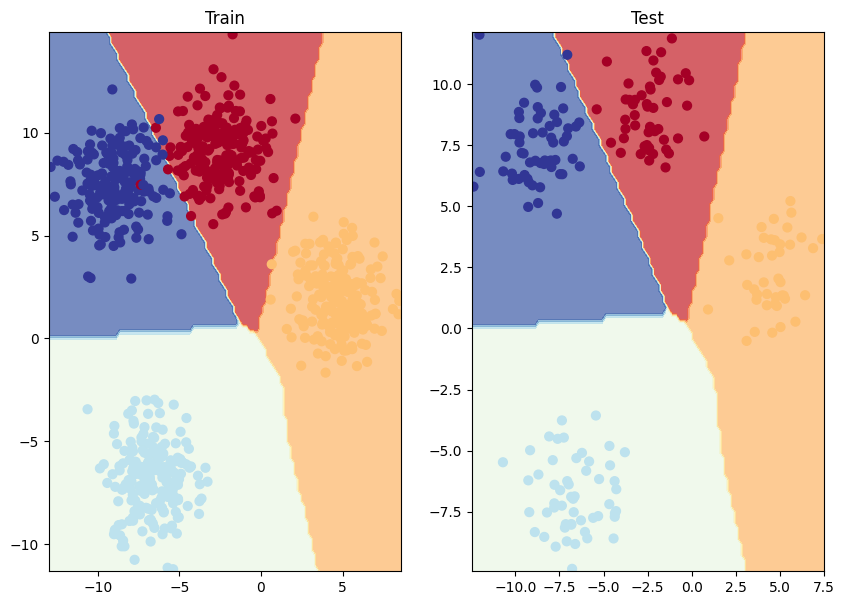

In [91]:
# Visualize

plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

# The thing is, we can get almost the same result by not using ReLU (non-linear activation)

## 9. A few more classification metrics... (to evaluiate our classification model)

* Accuracy - out of 100 samples how much does our model get right
* Precision
* Recall
* F1-Score
* Confusion matrix
* Classification report

Extra-curicculum - https://lightning.ai/docs/torchmetrics/stable/

In [92]:
!pip install torchmetrics

In [104]:
from torchmetrics import Accuracy, ConfusionMatrix, F1Score, Precision, Recall

# Setup metric
torchmetric_accuracy = Accuracy(task="multiclass",num_classes=4).to(device)
confussion_matrix = ConfusionMatrix(task="multiclass", num_classes=4).to(device)
F1Score = F1Score(task="multiclass", num_classes=4).to(device)
Precision = Precision(task="multiclass", num_classes=4).to(device)
Recall = Recall(task="multiclass", num_classes=4).to(device)

# Calculate accuracy
torchmetric_accuracy(y_preds, y_blob_test)


tensor(0.9950, device='cuda:0')

In [100]:
# Calculate confusion matrix
confussion_matrix(y_preds, y_blob_test)

tensor([[49,  0,  0,  0],
        [ 0, 41,  0,  0],
        [ 0,  0, 53,  0],
        [ 1,  0,  0, 56]], device='cuda:0')

In [101]:
# Calculate F1Score
F1Score(y_preds, y_blob_test)

tensor(0.9950, device='cuda:0')

In [105]:
# Calculate precision
Precision(y_preds, y_blob_test)

tensor(0.9950, device='cuda:0')

In [106]:
# Calculate recall
Recall(y_preds, y_blob_test)

tensor(0.9950, device='cuda:0')